# ภาคผนวก A รวมหลักการและวิธีการที่เกี่ยวข้อง

ในภาคผนวกนี้ได้รวบรวมหลักการและวิธีการที่สนับสนุนเนื้อหาหลักของหนังสือ 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## A.2 ข้อมูลอนุกรมเวลา

โมเดลข้อมูลลำดับในบทที่ 5 สามารถใช้พยากรณ์ข้อมูลอนุกรมเวลา (time series) ตัวอย่างเช่นในรูปที่ A.4
เป็นอนุกรมเวลาของจำนวนไมล์ต่อเดือนที่รถยนต์ทั้งหมดเดินทางในประเทศสหรัฐอเมริกา เก็บในช่วงเวลา ค.ศ. 2000 - 2014 เป็นเวลา 15 ปี 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1fODSgfgbAs0aY4AmUByYuFGXyuMMJi5m" width=550 />
</p>
<div align="center">รูปที่ A.4 จำนวนไมล์ต่อเดือนที่รถทั้งหมดในสหรัฐอเมริกาเดินทางในปี ค.ศ. 2000 - 2014 [ ]</div>


ข้อมูลอนุกรมเวลาโดยทั่วไปเป็นผลรวมองค์ประกอบหลักดังนี้

* แนวโน้ม (trend)
* ตามฤดูกาล (seasonal)
* การรบกวน (noise)
* สหสัมพันธ์อัตโนมัติ (autocorrelation)

โดยอาจมีองค์ประกอบเพียงบางตัวหรือทั้งหมดก็ได้ เนื้อหาในส่วนนี้จะเป็นการศึกษาพื้นฐานของอนุกรมเวลา 
โดยใช้ข้อมูลสังเคราะห์ซึ่งดัดแปลงจากที่ใช้สาธิตในวิชา "Sequence, Time Series and Prediction" โดย Laurence Moroney 
ไลบรารีที่ใช้คือ numpy และ matplotlib ที่นำเข้าในส่วนต้นของภาคผนวกนี้

นิยามฟังก์ชันสำหรับพล็อตอนุกรม

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None,xlabel="time (days)",ylabel="value"):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

### A.2.1 แนวโน้ม

แนวโน้มในข้อมูลคือแบบอย่างที่เป็นตัวบอกว่าค่าในระยะยาวเพิ่มขึ้นหรือลดลง ตัวอย่างเช่นจำนวนประชากรในกรุงเทพมหานครมีแนวโน้มมากขึ้น 
แนวโน้มจะแทนโดยกราฟเส้นตรงที่มีความชันเป็นตัวกำหนดการเพิ่มขึ้น/ลดลง/คงที่ นิยามฟังก์ชัน trend() สำหรับใช้ในการสร้างข้อมูลสังเคราะห์ดังนี้

In [4]:
def trend(t, slope=0):
    return slope * t

ทดลองสร้างข้อมูลรายวันในช่วงเวลา 4 ปี มีแนวโน้มที่มีความชัน -0.2 ดังแสดงในรูปที่ A.5 ผู้อ่านสามารถเปลี่ยนความชันตามต้องการ

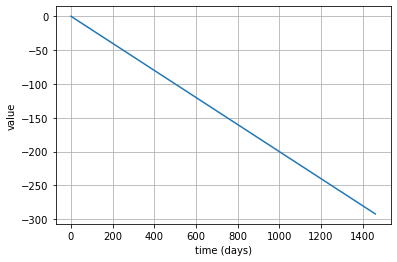

In [5]:
time = np.arange(4 * 365 + 1)
y_trend = trend(time, -0.2)
plot_series(time, y_trend)

รูปที่ A.5 กราฟเส้นตรงแทนแนวโน้มข้อมูลที่สร้างโดยฟังก์ชัน trend()

### A.2.2 องค์ประกอบตามฤดูกาล

องค์ประกอบตามฤดูกาลได้ชื่อเรียกมาจากลักษณะข้อมูลที่มีแบบรูปเหมือนกันในแต่ละฤดูของปี เช่นการท่องเที่ยวทางภาคใต้ของประเทศไทยซบเซาลงในช่วงฤดูฝน 
แต่สำหรับด้านวิทยาการข้อมูล นิยามนี้ครอบคลุมถึงองค์ประกอบที่มีลักษณะเป็นรายคาบโดยไม่คำนึงถึงหน่วยในแกนเวลา 
เช่นอุณหภูมิที่ลดต่ำในช่วงกลางคืนถึงเช้าและเพิ่มสูงในช่วงบ่ายก็สามารถจัดได้เป็นองค์ประกอบตามฤดูกาล 
หรือแม้แต่สัญญาณจากการสั่นสะเทือนของเครื่องจักรกลแบบหมุนที่ขาดสมดุลย์ที่มีคาบเวลาหน่วยมิลลิวินาที

ข้อมูลสังเคราะห์ที่ใช้ในหนังสือได้มาจากการนิยามฟังก์ชัน seasonality() ที่เรียกใช้ seasonal_pattern() 
โดยภายในฟังก์ชันนี้สร้างแบบรูปตามฤดูกาลขึ้นตามที่เราต้องการ 

In [6]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    -np.cos(season_time * 2.8 * np.pi),
                    -0.1*np.exp(2.3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

ทดลองสร้างข้อมูลตามฤดูกาลรายปีที่มี amplitude=50 ดังในรูปที่ A.6

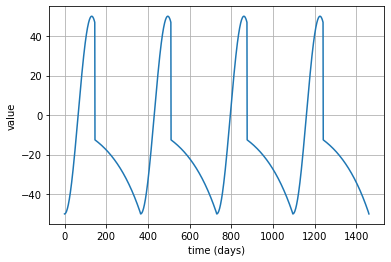

In [7]:
amplitude = 50
series = seasonality(time, period=365, amplitude=amplitude)
plot_series(time, series)

รูปที่ A.6 องค์ประกอบตามฤดูกาลสร้างโดยฟังก์ชัน seasonality()

เมื่อรวมแนวโน้มกับองค์ประกอบตามฤดูกาลเข้าด้วยกัน โดยให้ค่าเริ่มต้นเท่ากับ 50 ความชัน -0.05 ได้ดังรูปที่ A.7

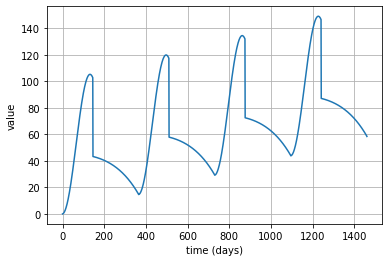

In [8]:
baseline = 50
slope = 0.04
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
plot_series(time, series)

รูปที่ A.7 กราฟจากการรวมแนวโน้มและองค์ประกอบตามฤดูกาล

### A.2.3 การรบกวน

โดยทั่วไปการรบกวนที่เกิดขึ้นในการวัดหรือจัดเก็บข้อมูลจะถูกโมเดลเป็นค่าสุ่ม เช่นสัญญาณรบกวนสีขาว (white noise) 
นิยามฟังก์ชัน noise() สำหรับกำเนิดการรบกวนได้ดังนี้

In [9]:
def noise(time, noise_level=1):
    return np.random.randn(len(time)) * noise_level

พล็อตการรบกวนที่กำเนิดจากฟังก์ชัน noise() ได้ดังรูปที่ A.8

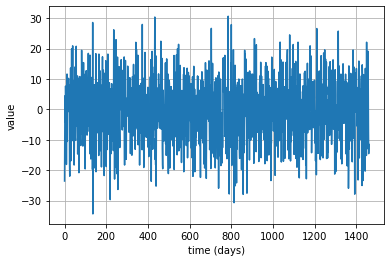

In [10]:
plot_series(time,noise(time, noise_level=10))

รูปที่ A.8 การรบกวนที่สร้างโดยฟังก์ชัน noise()

เมื่อเพิ่มการรบกวนให้กับกราฟในรูปที่ A.7 จะได้เป็นดังรูปที่ A.9 

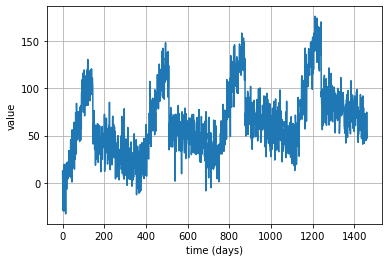

In [11]:
noise_level = 15
noisy_series = series + noise(time, noise_level)
sample_time = time  # to be used later on
plot_series(time, noisy_series)

รูปที่ A.9 ข้อมูลสังเคราะห์ที่เพิ่มการรบกวน

### A.2.4 สหสัมพันธ์อัตโนมัติ 

องค์ประกอบอีกรูปแบบหนึ่งที่อาจพบได้ในข้อมูลเรียกว่า สหสัมพันธ์อัตโนมัติ (autocorrelation) ดังตัวอย่างในรูปที่ A.10 
เป็นผลรวมของอิมพัลส์ที่เกิดขึ้นแบบสุ่ม กับสหสัมพันธ์อัตโนมัติ $v(t) = 0.99v(t-1)$ ซึ่งเป็นค่าเชิงกำหนด (deterministic)


In [12]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

In [13]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

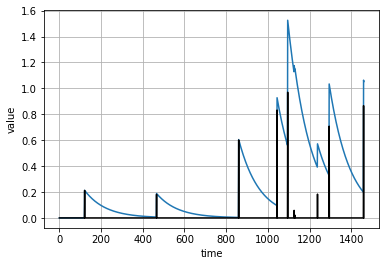

In [14]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series,xlabel="time")
plt.plot(time,signal, "k-")
plt.show()

รูปที่ A.10 ข้อมูลอนุกรมเวลาที่เป็นผลรวมของอิมพัลส์กับสหสัมพันธ์อัตโนมัติ

ตัวอย่างเพิ่มเติมของข้อมูลสหสัมพันธ์อัตโนมัติแสดงได้ดังในรูปที่ A.11 และ A.12

In [15]:
def autocorrelation1(time, amplitude):
    rho1 = 0.7
    rho2 = -0.3
    ar = np.random.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += rho1 * ar[step - 50]
        ar[step] += rho2 * ar[step - 33]
    return ar[50:] * amplitude

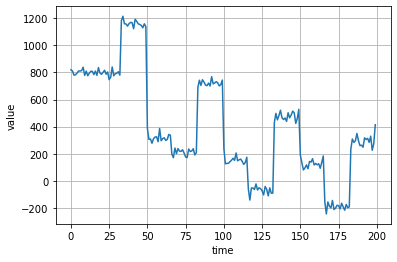

In [16]:
series = autocorrelation1(time, 20)
plot_series(time[:200], series[:200],xlabel="time")

รูปที่ A.11 ตัวอย่างข้อมูลสหสัมพันธ์อัตโนมัติ

In [17]:
def autocorrelation2(time, amplitude):
    rho = 0.6
    ar = np.random.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += rho * ar[step - 1]
    return ar[1:] * amplitude

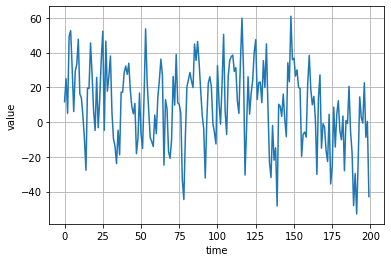

In [18]:
series = autocorrelation2(time, 20)
plot_series(time[:200], series[:200], xlabel="time")

รูปที่ A.12 ตัวอย่างข้อมูลสหสัมพันธ์อัตโนมัติ

รูปที่ A.13 แสดงตัวอย่างข้อมูลที่เป็นการผสมผสานแนวโน้ม องค์ประกอบเชิงฤดูกาล และสหสัมพันธ์อัตโนมัติ

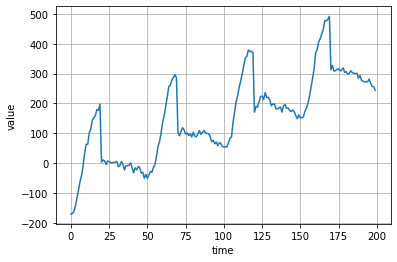

In [19]:
series = autocorrelation2(time, 10) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200],xlabel="time")

รูปที่ A.13 ข้อมูลจากการรวมแนวโน้ม องค์ประกอบตามฤดูกาล และสหสัมพันธ์อัตโนมัติ

### A.2.5 อนุกรมเวลาไม่คงที่

ในกรณีที่ข้อมูลมีรูปแบบแน่นอนจนกระทั่งถึงจุดหนึ่งที่มีการเปลี่ยนแปลงรูปแบบไป เรียกว่าอนุกรมเวลาไม่คงที่ (non-stationary) 
สาเหตุอาจเกิดจากมีเหตุการสำคัญที่ส่งผลกระทบอย่างรุนแรง 
ตัวอย่างเช่นข้อมูลจำนวนนักท่องเที่ยวทางภาคใต้ในทุกปีจะมากในช่วงฤดูร้อนและน้อยในฤดูฝน แต่เมื่อมีการระบาดหนักของโควิด-19 
จำนวนนักท่องเที่ยวลดลงเหลือน้อยมากตลอดปี

รูปที่ A.14 แสดงตัวอย่างอนุกรมเวลาไม่คงที่จากข้อมูลสังเคราะห์ที่มีการเปลี่ยนแปลงแบบรูป ณ เวลา $t = 180$ 
ในการเลือกข้อมูลเพื่อฝึกโมเดลจะต้องพิจารณาในส่วนนี้ เพราะโดยทั่วไปเรามักยึดติดกับแนวคิดว่ายิ่งมีข้อมูลฝึกมากยิ่งดี 
แต่ในกรณีนี้การเลือกข้อมูลฝึกหลังจาก $t = 180$ จะให้ผลดีกว่า

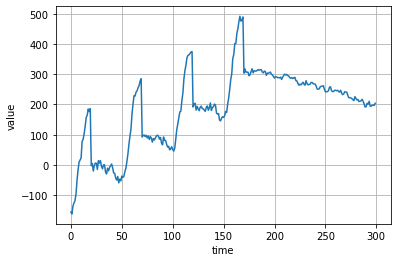

In [20]:
series = autocorrelation2(time, 10) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation2(time, 5) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 500
series[180:] = series2[180:]
plot_series(time[:300], series[:300],xlabel="time")

รูปที่ A.14 ตัวอย่างอนุกรมเวลาไม่คงที่

## A.3 การพยากรณ์ข้อมูลอนุกรมเวลา

ข้อมูลอนุกรมเวลาที่เราประสบในชีวิตจริงอาจประกอบด้วยลักษณะเด่น 4 รูปแบบดังที่ได้กล่าวมาข้างต้น 
วัตถุประสงค์หลักคือสามารถตรวจจับรูปแบบเหล่านี้เพื่อพยากรณ์ค่าในอนาคตได้ 
(ยกเว้นส่วนของการรบกวนที่ไม่สามารถคา่ดเดาได้)

ในการเลือกข้อมูลสำหรับฝึกและทดสอบ หากข้อมูลมีองค์ประกอบตามฤดูกาล ควรแบ่งส่วนให้แต่ละส่วนครอบคลุมจำนวนเต็มของคาบเวลา 
ตัวอย่างเช่นแบบรูปตามฤดูกาลเป็นรายปี ให้่เลือกข้อมูลฝึกเป็นจำนวนเต็มของปี เช่น 3 ปี ไม่ควรเลือก 1.5 ปี 
เพราะจะทำให้บางส่วนของข้อมูลรายคาบถูกใช้ในการฝึกมากกว่าส่วนอื่น รูปที่ A.15 แสดงการแบ่งส่วนคงที่ (fixed partitioning) 
สำหรับตัวอย่างข้อมูลในรูปที่ A.9 เป็นข้อมูลฝึก ตรวจสอบ และทดสอบ 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1umwiZHMGiFJxhI-8mvK7W4_nxWWwIFD-" width=650 />
</p>
<div align="center">รูปที่ A.15 ตัวอย่างการแบ่งส่วนคงที่สำหรับข้อมูลฝึก ตรวจสอบ และทดสอบ</div>

อีกวิธีการหนึ่งที่นิยมใช้ในการแบ่งข้อมูลแสดงในรูปที่ A.16 
คือแบ่งข้อมูลทั้งหมดที่มีอยู่สำหรับการฝึกและตรวจสอบ ส่วนการทดสอบย้ายไปยังเวลาในอนาคต 

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1GRj15vzWTehvJo45zH3uv60irLWYEqto" width=650 />
</p>
<div align="center">รูปที่ A.16 อีกวิธีการหนึ่งในการแบ่งส่วนข้อมูลสำหรับฝึก ตรวจสอบ และทดสอบ</div>

### A.3.1 ตัววัดสมรรถนะ

ในการศึกษาว่าโมเดลสามารถพยากรณ์ได้ดีเพียงใด เราต้องการตรวจสอบค่าความผิดพลาดในการพยากรณ์ 
(ซึ่งก็ไม่แตกต่างจากค่าสูญเสียของโมเดลถดถอยเชิงเส้นในบทที่ 2) พิจารณาค่าผิดพลาด

$$
e(t) = y(t) - \hat{y}(t) \tag{A.4}
$$

โดย $y(t)$ และ $\hat{y}(t)$ คือค่าจริงและค่าที่พยากรณ์ตามลำดับ จะเห็นว่าค่าผิดพลาด (A.4) 
อาจมีค่าเป็นบวกและลบในแต่ละขั้นเวลา ดังนั้นเมื่อรวมเข้าด้วยกันอาจหักล้างกันทำให้มีค่ารวมน้อยลง 
ซึ่งไม่ใช่สิ่งที่เราต้องการ ดังนั้นจะต้องมีการแปลงให้เป็นค่าบวกทั้งหมดโดยการยกกำลังสองหรือใช้ค่าสัมบูรณ์ 
กำหนดตัวแปร errors เป็นเวกเตอร์เก็บค่าผิดพลาดของข้อมูลตาม (A.4) ในช่วงเวลาที่ต้องการ 
ตัววัดที่นิยมใช้มีดังนี้

```python
mse = np.square(errors).mean()
rmse = np.sqrt(mse)
mae = np.abs(errors).mean()
mape = np.abs(errors/x_valid).mean()
```
โดย mse (mean square error), rmse (root mean square error), mae (mean absolute error), 
mape (mean absolute percentage error) ทั้งหมดมีค่าเป็นบวกที่เป็นดัชนีของความแม่นยำในการพยากรณ์ 
สังเกตว่า mse, rmse จะใช้วิธียกกำลังสองค่าผิดพลาด ดังนั้นค่าผิดพลาดที่มีค่าสูงจะถูกให้น้ำหนักมากกว่า 
หากไม่ใช่สิ่งที่ต้องการควรเลือกใช้ mae หรือ mape (x_valid คือค่าของอินพุต)

เราสามารถเลือกใช้ตัววัดที่ต้องการได้จากไลบรารี keras ได้ ตัวอย่างเช่น mse และ mae ใช้คำสั่งดังนี้
```python
keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy()
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()
```

### A.3.2 เส้นฐานการพยากรณ์

หากเราต้องการวิเคราะห์ว่าการพยากรณ์โดยโมเดลการเรียนรู้เชิงลึกได้ผลดีมากน้อยเพียงใด จำเป็นต้องมีค่าวัดที่เป็นเส้นฐาน 
(baseline) โดยเราจะใช้วิธีการแบบง่ายสุดคือ ให้ค่าการพยากรณ์เท่ากับค่าสุดท้ายของข้อมูล 
ทดลองใช้กับข้อมูลที่มีการรบกวนในรูปที่ A.9 (ซึ่งต่อไปจะใช้ข้อมูลจาก sample_series 
และ sample_time นี้เป็นตัวอย่างประกอบเนื้อหา) 
แบ่งส่วนข้อมูลสำหรับฝึกและตรวจสอบที่เวลา $t = 1095$ คือใช้ข้อมูล 3 ปีสำหรับฝึกและ 1 ปีสำหรับตรวจสอบ
รูปที่ A.17 และ A.18 แสดงอนุกรมเวลาที่แยกเป็นข้อมูลฝึกและทดสอบตามลำดับ


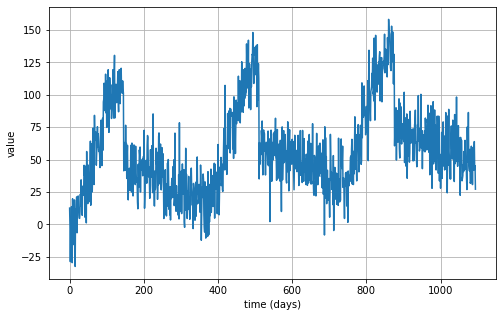

In [21]:
sample_series = noisy_series
split_time = 365*3
time_train = sample_time[:split_time]
x_train = sample_series[:split_time]
time_valid = sample_time[split_time:]
x_valid = sample_series[split_time:]
plt.figure(figsize=(8,5))
plot_series(time_train, x_train)
plt.show()

รูปที่ A.17 ข้อมูลสำหรับการฝึก

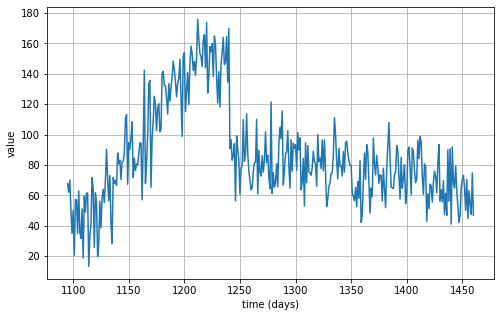

In [22]:
plt.figure(figsize=(8, 5))
plot_series(time_valid, x_valid)
plt.show()

รูปที่ A.18 ข้อมูลสำหรับตรวจสอบ

การพยากรณ์อย่างง่ายให้ผลเป็นดังรูปที่ A.19 

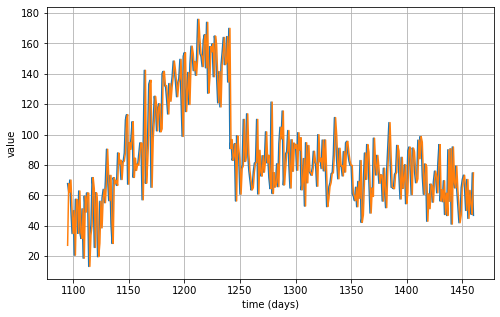

In [25]:
naive_forecast = sample_series[split_time - 1:-1]
plt.figure(figsize=(8, 5))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

รูปที่ A.19 ผลจากการพยากรณ์อย่างง่าย

ซึ่งดูเหมือนเป็นการพยากรณ์ที่ดี แต่หากขยายกราฟดังในรูปที A.20 จะเห็นว่ากราฟการพยากรณ์ล้าหลังข้อมูลจริงอยู่ 1 วัน

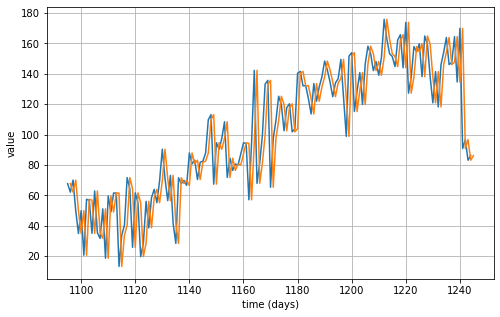

In [26]:
plt.figure(figsize=(8, 5))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

รูปที่ A.20 ผลจากการพยากรณ์อย่างง่ายเมื่อขยายแกนเวลา

ตรวจสอบค่าตัววัด mse และ mae ที่เราจะใช้เป็นค่าเส้นฐาน

In [27]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

434.3780304104924
16.27624466936418


### A.3.3 การจัดรูปข้อมูลอนุกรมเวลา

ในการพยากรณ์โดยโมเดลเรียนรู้เชิงลึก เราต้องจัดข้อมูลให้อยู่ในรูปแบบของการเรียนรู้โดยมีผู้สอนที่ได้ศึกษาในหนังสือนี้ 
โดยประกอบด้วยอินพุต $X$ ที่ป้อนให้กับโมเดลเพื่อพยากรณ์ $\hat{y}$ เปรียบเทียบกับข้อมูลจริงคือเลเบล $y$ 
วิธีการที่ใช้คือสร้างหน้าต่างของเวลาดังรูปที่ A.21 โดยกำหนดจำนวนจุดเวลาในหน้าต่างเช่น 30 วัน 
หรือตามที่ต้องการ ข้อมูลในหน้าต่างยกเว้นค่าสุดท้ายคืออินพุต $X$ ของโมเดล 
และข้อมูลค่าสุดท้ายคือเลเบล $y$ 
กวาดหน้าต่างนี้ตั้งแต่เริ่มต้นของอนุกรมเวลาไปยังจุดสิ้นสุดของข้อมูลที่แบ่งสำหรับการฝึก

<p />  
<p align="center">
<img src="https://drive.google.com/uc?id=1_1UMBmXt_dFstc9D9txFF0sqYnx42prV" width=650 />
</p>
<div align="center">รูปที่ A.21 การจัดรูปอนุกรมเวลาสำหรับการเรียนรู้เชิงลึก</div>


ก่อนที่จะดำเนินการกับข้อมูลอนุกรมเวลาสังเคราะห์ เพื่อให้เข้าใจถึงหลักการและโค้ดที่ใช้ 
จะสาธิตวิธีการจัดรูปโดยใช้ค่าตัวเลขที่กำเนิดขึ้นอย่างง่ายคือ 0-9 

In [28]:
dataset = tf.data.Dataset.range(10)

ทดลองจัดรูปโดยใช้หน้าต่างขนาด 5 และเลื่อนหน้าต่างครั้งละ 1 ขั้นเวลา 
หลังจากนั้นตัดส่วนตัวเลขที่ไม่ครบ 5 ทิ้งไปโดยกำหนด drop_remainder=True

In [29]:
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


สร้างส่วนของเลเบลเป็นตัวเลขที่ถัดจากค่าสุดท้ายของหน้าต่าง

In [30]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


ใช้เมธอด dataset.shuffle() เพื่อสลับข้อมูล

In [31]:
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
    print(x.numpy(), y.numpy())

[2 3 4 5] [6]
[5 6 7 8] [9]
[0 1 2 3] [4]
[3 4 5 6] [7]
[4 5 6 7] [8]
[1 2 3 4] [5]


ต่อมาคือการจัดกลุ่มย่อยโดยเลือกเท่ากับ 2 

In [32]:
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[5 6 7 8]
 [4 5 6 7]]
y =  [[9]
 [8]]
x =  [[2 3 4 5]
 [1 2 3 4]]
y =  [[6]
 [5]]
x =  [[3 4 5 6]
 [0 1 2 3]]
y =  [[7]
 [4]]


**ตัวอย่าง A.3**

ในขั้นแรกจะทดลองพยากรณ์โดยโมเดลชั้นเดี่ยว หรือโมเดลถดถอยเชิงเส้นในบทที่ 2 
และเปรียบเทียบตัววัดค่าผิดพลาดกับค่าเส้นฐาน ใช้วิธ๊การจัดรูปข้อมูลที่สาธิตก่อนหน้านี้กับข้อมูลในรูปที่ A.17, A.18 
โดยเลือกขนาดหน้าต่างเท่ากับ 20 ข้อมููลที่ใช้อยู่ในตัวแปร x_train, x_valid, time_train, time_valid จากด้านบน

In [33]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [34]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [35]:
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

สร้างชั้นของโมเดลที่มีขนาดอินพุตเท่ากับขนาดหน้าต่าง และเอาต์พุตค่าเดียว

In [36]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

คอมไพล์โมเดลโดยเลือกค่าสูญเสียแบบ mse และตัวหาค่าเหมาะที่สุดตามต้องการ ในตัวอย่างนี้เลือกเป็นแบบ 
SGD ที่มีการใช้โมเมนตัม

In [49]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

ฝึกโมเดลเป็นจำนวน 100 รอบ

In [38]:
model.fit(train_dataset,epochs=100,verbose=0)

ตรวจสอบค่าพารามิเตอร์จากการเรียนรู้หลังการฝึกเสร็จสิ้น

In [39]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.03568586],
       [ 0.01343471],
       [-0.03823332],
       [-0.00935871],
       [-0.00287514],
       [-0.01209861],
       [-0.01534943],
       [ 0.02018438],
       [ 0.04501085],
       [-0.03893059],
       [ 0.01673399],
       [ 0.0753949 ],
       [ 0.13711569],
       [ 0.07956365],
       [ 0.03806845],
       [ 0.09792581],
       [ 0.11916242],
       [ 0.13742635],
       [ 0.19302227],
       [ 0.14129333]], dtype=float32), array([0.04030978], dtype=float32)]


โดยในแอเรย์ชุดแรกคือค่าน้ำหนัก $w^{<t_0>}, w^{<t_1>},\ldots ,w^{<t_{19}>}$ 
ส่วนค่าสุดท้ายที่มีค่าเดียวคือค่าเอนเอียง $b$
ดังนั้นเอาต์พุตของโมเดลเขียนได้อยู่ในรูป

$$
\hat{y} = w^{<t_0>}x^{<t_0>} + w^{<t_1>}x^{<t_1>} + \ldots + w^{<t_{19}>}x^{<t_{19}>} \tag{A.5}
$$

ใช้ข้อมูลตรวจสอบเพื่อดูผลการพยากรณ์จากโมเดลที่ผ่านการฝึก ได้ผลดังแสดงในรูปที่ A.22

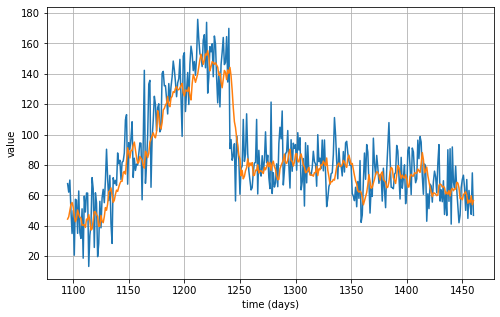

In [40]:
forecast = []

for t in range(len(sample_series) - window_size):
    forecast.append(model.predict(sample_series[t:t + window_size][np.newaxis],verbose=0))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(8, 5))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

รูปที่ A.22 ผลจากการพยากรณ์โดยโมเดลถดถอยเชิงเส้น

ถึงแม้ว่าการเปรียบเทียบกราฟด้วยตาอาจดูด้อยกว่าวิธีเส้นฐาน 
แต่เมื่อเปรียบเทียบค่าผิดพลาดจากการพยากรณ์ (วิธีการอย่างง่ายได้ค่า mse=489.2406782463387,
mae=17.498463190037835) พบว่าได้ค่าน้อยลง แสดงว่าการพยากรณ์โดยโมเดลชั้นเดี่ยวให้ผลที่ดีกว่า

In [41]:
print(keras.metrics.mean_squared_error(x_valid, results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, results).numpy())

306.416
14.010728


**ตัวอย่าง A.4**

ในตัวอย่างนี้จะใช้โมเดล DNN 3 ชั้นที่มีจำนวนเซลล์ในชั้นแฝง 10,10,1 ในการพยากรณ์ข้อมูลเดิมจากตัวอย่างที่ผ่านมา 
การจัดรูปข้อมูลจะไม่มีอะไรแตกต่างกัน ดังนั้นจะเริ่มโค้ดตรงส่วนการสร้างโมเดล คอมไพล์และฝึกเป็นจำนวน 100 รอบเท่ากัน

In [42]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])


In [48]:
dnn_model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [44]:
history=dnn_model.fit(train_dataset,epochs=100,verbose=0)

พล็อตค่าสูญเสียจากข้อมูลฝึกได้ดังในรูปที่ A.23

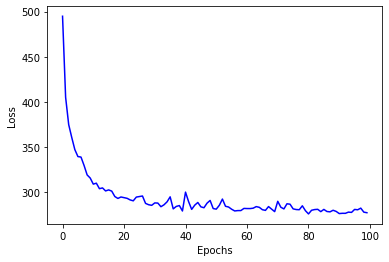

In [45]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

รูปที่ A.23 ค่าสูญเสียระหว่างการฝึก

ใช้ข้อมูลตรวจสอบเพื่อดูผลการพยากรณ์จากโมเดลที่ผ่านการฝึก ได้ผลดังแสดงในรูปที่ A.24

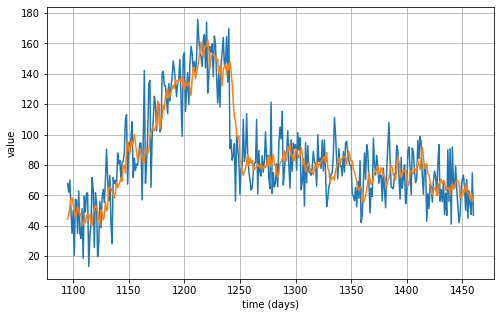

In [46]:
dnn_forecast = []
for t in range(len(sample_series) - window_size):
    dnn_forecast.append(dnn_model.predict(sample_series[t:t + window_size][np.newaxis],verbose=0))

dnn_forecast = dnn_forecast[split_time-window_size:]
dnn_results = np.array(dnn_forecast)[:, 0, 0]

plt.figure(figsize=(8, 5))

plot_series(time_valid, x_valid)
plot_series(time_valid, dnn_results)

รูปที่ A.24 ผลจากการพยากรณ์โดยโมเดล DNN

ตรวจสอบค่าผิดพลาดจากการพยากรณ์ พบว่ามีค่าน้อยลงกว่าโมเดลถดถอยเชิงเส้น

In [47]:
print(keras.metrics.mean_squared_error(x_valid, dnn_results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, dnn_results).numpy())

298.7249
13.627929


<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja 2022</div>